# Adversarial Search: Playing Connect 4

Student Name: Logan Choi

I have used the following AI tools: ChatGPT

I understand that my submission needs to be my own work: LC

## Instructions

Total Points: Undergraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file.


## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
  * The board is a 6-row by 7-column grid, initially empty. It’s the first player’s turn (typically "X").
    * Representation: We can represent the board as a 2D list or NumPy array.
    * Player turn: Keep track of whose turn it is.
* Actions
  * Each action is dropping a piece into one of the 7 columns (0-6) if the column is not full.
    * Valid actions: Columns where at least one cell is empty from the bottom up.
* Transition model (result function)
  * Given a state and an action (a column number), the function returns a new state:
    * The piece of the current player is placed in the lowest empty row in the selected column.
    * The turn switches to the other player.
* Goal state (terminal state and utility)
  * Terminal states occur if:
    * A player connects 4 in a row (horizontally, vertically, or diagonally).
    * The board is full (draw).
  * Utility:
    * +1 if Player X wins
    * -1 if Player O wins
    * 0 if draw

Describe each component and then implement it as a function that can be used by search algorithms.

In [29]:
# Your code/answer goes here.
import numpy as np

ROWS = 6
COLUMNS = 7
PLAYER_X = 1  # "X"
PLAYER_O = -1  # "O"
EMPTY = 0

# Initialize an empty board
def initial_state():
    return np.zeros((ROWS, COLUMNS), dtype=int), PLAYER_X

# Return valid actions (columns that are not full)
def actions(state):
    board, _ = state
    return [col for col in range(COLUMNS) if board[0][col] == EMPTY]

# Drop a piece into the lowest empty spot in the chosen column
def result(state, action):
    board, player = state
    new_board = board.copy()
    for row in reversed(range(ROWS)):
        if new_board[row][action] == EMPTY:
            new_board[row][action] = player
            break
    return new_board, -player

# Check for terminal state and return (is_terminal, utility)
def is_terminal(state):
    board, _ = state

    def check_winner(player):
        # Horizontal
        for r in range(ROWS):
            for c in range(COLUMNS - 3):
                if np.all(board[r, c:c+4] == player):
                    return True
        # Vertical
        for r in range(ROWS - 3):
            for c in range(COLUMNS):
                if np.all(board[r:r+4, c] == player):
                    return True
        # Diagonal /
        for r in range(3, ROWS):
            for c in range(COLUMNS - 3):
                if all(board[r-i][c+i] == player for i in range(4)):
                    return True
        # Diagonal \
        for r in range(ROWS - 3):
            for c in range(COLUMNS - 3):
                if all(board[r+i][c+i] == player for i in range(4)):
                    return True
        return False

    if check_winner(PLAYER_X):
        return True, +1
    if check_winner(PLAYER_O):
        return True, -1
    if np.all(board != EMPTY):
        return True, 0  # Draw
    return False, None  # Game not over

How big is the state space? Give an estimate and explain it.

The Connect 4 board has 6 rows and 7 columns, totaling 42 cells. Each cell can be empty, contain Player X's disc, or Player O's disc, giving a theoretical maximum of:

**3^42 ≈ 1.09 × 10^20** possible configurations.

However, most of these configurations are illegal due to gravity (discs must stack from the bottom) and turn alternation rules.

According to Victor Allis (1988), who solved Connect 4, the actual number of **legal**, reachable game states is approximately:

**4.5 trillion (4.5 × 10^12)**

How big is the game tree that minimax search will go through? Give an estimate and explain it.

The game tree for Connect 4 represents all possible sequences of moves from the initial board state.

- The maximum depth of the tree is 42 (one move per cell).
- The average branching factor is around 4–7.

A naïve upper bound is:
**6^42 ≈ 5.1 × 10^32 nodes**

However, due to early terminations (wins), invalid move sequences, and board symmetries, researchers estimate the practical size of the game tree to be:

**Approximately 10^21 nodes**

This enormous size makes exhaustive Minimax search infeasible, which is why we use:
- Depth-limited Minimax
- Alpha-beta pruning
- Heuristic evaluation functions

to build intelligent agents that play efficiently.

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [30]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

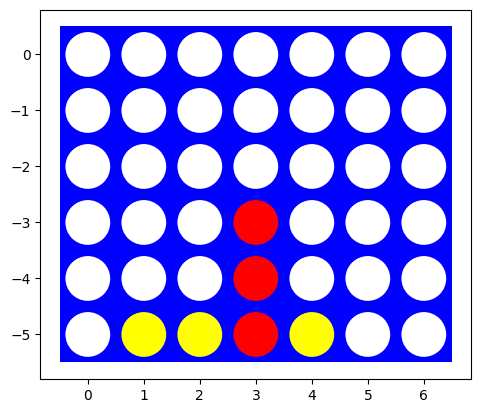

In [31]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(state)`.
* The transition model `result(state, player, action)`.
* Check for terminal states `terminal(state)`.
* The utility function `utility(state, player)`.

The player argument is used so your agent can play red or yellow.
Make sure that all these functions work with boards of different sizes (number of columns and rows).
You can follow the [tic-tac-toe example from class.](https://colab.research.google.com/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_definitions.ipynb)

In [32]:
# Your code/ answer goes here.
def actions(state):
    """Return a list of valid columns (actions) for the current state."""
    return [col for col in range(state.shape[1]) if state[0, col] == 0]

def result(state, player, action):
    """Return a new board after the player drops a piece in the given column."""
    new_state = state.copy()
    for row in range(state.shape[0] - 1, -1, -1):
        if new_state[row, action] == 0:
            new_state[row, action] = player
            return new_state
    raise ValueError("Invalid move: column is full.")

def terminal(state):
    return check_winner(state) is not None or np.all(state != 0)

def check_winner(state):
    """Check all directions for 4-in-a-row and return the winning player if any."""
    rows, cols = state.shape
    directions = [(1, 0), (0, 1), (1, 1), (1, -1)]  # vertical, horizontal, diagonals

    for r in range(rows):
        for c in range(cols):
            if state[r, c] == 0:
                continue
            player = state[r, c]
            for dr, dc in directions:
                try:
                    if all(
                        0 <= r + dr * i < rows and
                        0 <= c + dc * i < cols and
                        state[r + dr * i, c + dc * i] == player
                        for i in range(4)
                    ):
                        return player
                except IndexError:
                    continue
    return None

def utility(state, player):
    winner = check_winner(state)
    if winner == player:
        return 1
    elif winner == -player:
        return -1
    else:
        return 0

Actions: [0, 1, 2, 3, 4, 5, 6]
Terminal? True
Utility for player 1: 1


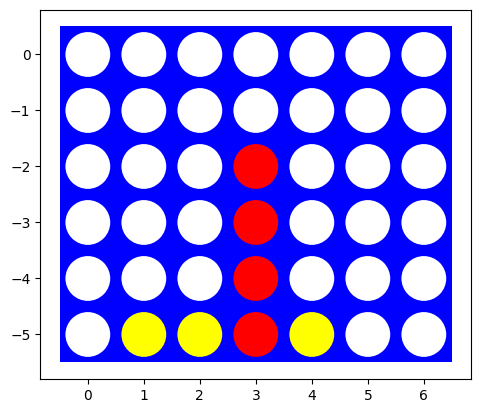

In [33]:
import numpy as np

# Test setup
board = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0],
                  [0,-1,-1, 1,-1, 0, 0]])

print("Actions:", actions(board))
print("Terminal?", terminal(board))
print("Utility for player 1:", utility(board, 1))

visualize(board)

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [34]:
# Your code/ answer goes here.
import random

def random_player(board, player=1):
    """Select a random valid action (column) for the current board."""
    valid_moves = actions(board)
    if not valid_moves:
        return None  # No moves possible
    return random.choice(valid_moves)


Random Player chose column: 3


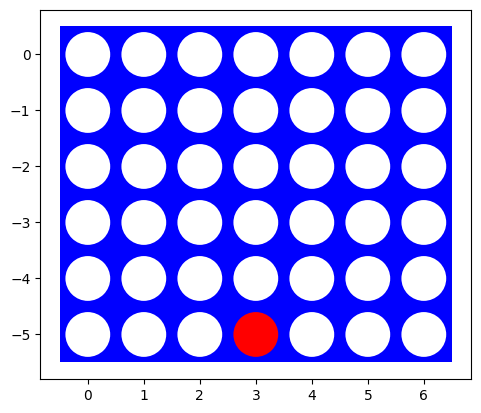

In [35]:
# Create a fresh board
board = empty_board()

# Let random player make a move
move = random_player(board, player=1)

print("Random Player chose column:", move)

# Apply move
new_board = result(board, 1, move)

# Visualize the new board
visualize(new_board)

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [36]:
# Your code/ answer goes here.
def play_game(agent1, agent2, verbose=False):
    board = empty_board()
    player = 1  # Red goes first
    while not terminal(board):
        if player == 1:
            move = agent1(board, player)
        else:
            move = agent2(board, player)

        if move is None:
            break  # No possible move

        board = result(board, player, move)
        player *= -1  # Switch turns

    winner = utility(board, 1)
    if verbose:
        visualize(board)
        print("Winner:", "Red" if winner == 1 else "Yellow" if winner == -1 else "Draw")
    return winner

In [37]:
results = {1: 0, -1: 0, 0: 0}

for _ in range(1000):
    outcome = play_game(random_player, random_player)
    results[outcome] += 1

print("Red wins:", results[1])
print("Yellow wins:", results[-1])
print("Draws:", results[0])

Red wins: 561
Yellow wins: 437
Draws: 2


## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.

__Important Notes:__
* You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The game tree for a $6 \times 7$ board is huge and optimal algorithms need to visit each or a large percentage of all nodes in the tree. You can experiment with smaller boards like a $4 \times 4$ board first.

In [38]:
# Your code/ answer goes here.
class MinimaxAgent:
    def __init__(self, depth_limit=4, use_ordering=False):
        self.depth_limit = depth_limit
        self.nodes_searched = 0  # Optional: for stats

    def __call__(self, board, player=1):
        best_score = float('-inf')
        best_move = None
        alpha = float('-inf')
        beta = float('inf')

        for move in actions(board):
            new_board = result(board, player, move)
            score = self.min_value(new_board, self.depth_limit - 1, alpha, beta, -player)
            if score > best_score:
                best_score = score
                best_move = move
            alpha = max(alpha, best_score)

        return best_move

    def max_value(self, board, depth, alpha, beta, player):
        self.nodes_searched += 1
        if terminal(board) or depth == 0:
            return utility(board, player)

        value = float('-inf')
        for move in actions(board):
            value = max(value, self.min_value(result(board, player, move), depth - 1, alpha, beta, -player))
            if value >= beta:
                return value
            alpha = max(alpha, value)
        return value

    def min_value(self, board, depth, alpha, beta, player):
        self.nodes_searched += 1
        if terminal(board) or depth == 0:
            return utility(board, -player)

        value = float('inf')
        for move in actions(board):
            value = min(value, self.max_value(result(board, player, move), depth - 1, alpha, beta, -player))
            if value <= alpha:
                return value
            beta = min(beta, value)
        return value

In [39]:
minimax_agent = MinimaxAgent(depth_limit=4)

board = empty_board()
move = minimax_agent(board, player=1)

print("Minimax agent selects column:", move)

Minimax agent selects column: 0


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

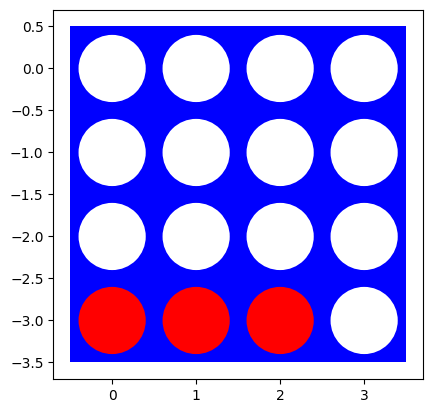

Agent move: 3


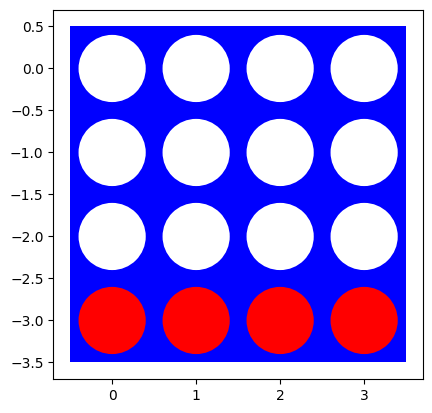

In [40]:
board1 = np.array([
    [0,  0,  0,  0],
    [0,  0,  0,  0],
    [0,  0,  0,  0],
    [1,  1,  1,  0]  # agent = 1 should place at col 3 to win
])

visualize(board1)
move = minimax_agent(board1, player=1)
print("Agent move:", move)
board = result(board1, 1, move)
visualize(board)


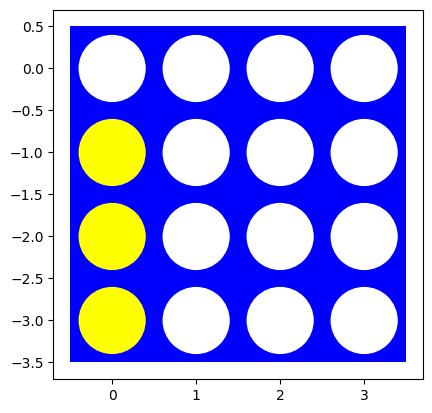

Agent move: 0


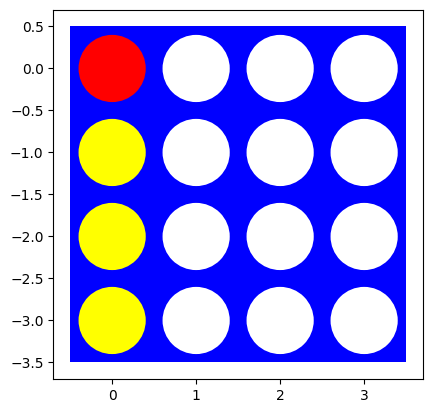

In [41]:
board2 = np.array([
    [0, 0,  0,  0],
    [-1, 0,  0,  0],
    [-1, 0,  0,  0],
    [ -1, 0,  0,  0]  # player -1 can win next move if not blocked at col 0
])

visualize(board2)
move = minimax_agent(board2, player=1)
print("Agent move:", move)
board = result(board2, 1, move)
visualize(board)

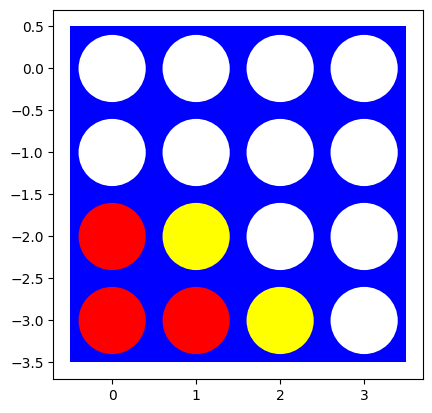

Agent move: 0


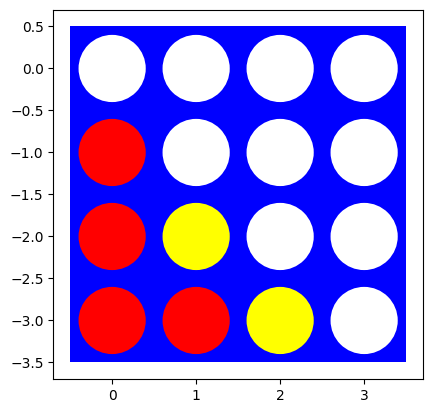

In [42]:
board3 = np.array([
    [0,  0,  0,  0],
    [0,  0,  0,  0],
    [1, -1, 0,  0],
    [1,  1, -1, 0]  # red (1) should place in col 3 to complete diagonal
])

visualize(board3)
move = minimax_agent(board3, player=1)
print("Agent move:", move)
board = result(board3, 1, move)
visualize(board)

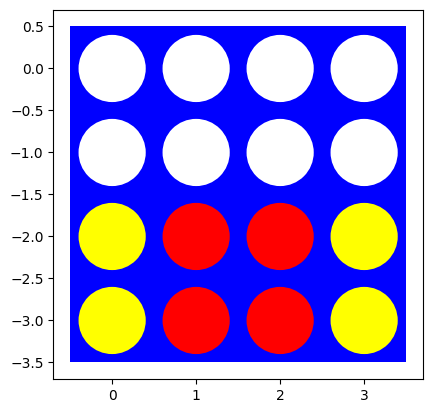

Agent move: 0


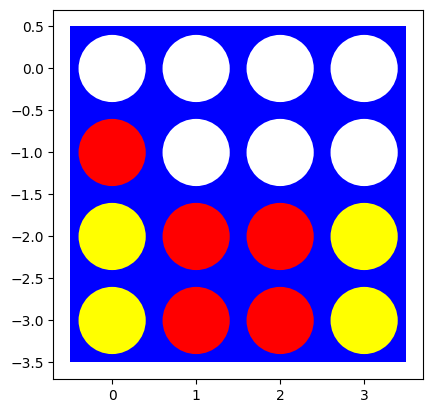

In [43]:
board4 = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [-1, 1, 1, -1],
    [-1, 1, 1, -1]  # agent = 1 must play on top row now
])

visualize(board4)
move = minimax_agent(board4, player=1)
print("Agent move:", move)
board = result(board4, 1, move)
visualize(board)

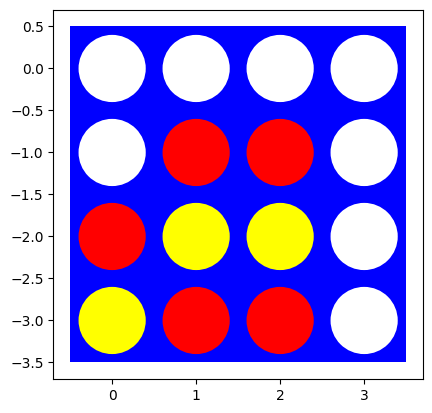

Agent move: 0


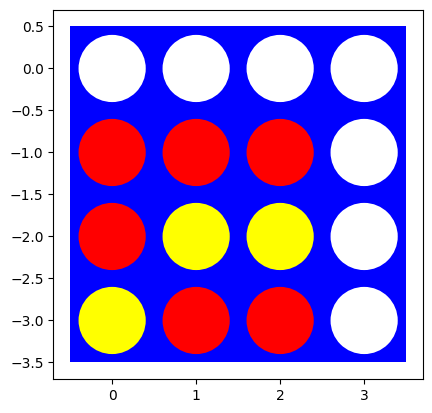

In [44]:
board5 = np.array([
    [0, 0, 0, 0],
    [0, 1, 1, 0],
    [1,-1,-1, 0],
    [-1, 1, 1, 0]  # agent should create fork or pick winning move
])

visualize(board5)
move = minimax_agent(board5, player=1)
print("Agent move:", move)
board = result(board5, 1, move)
visualize(board)

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns/rows. Explain why using this algorithm on a standard $6 \times 7$ board takes forever.

In [45]:
# Your code/ answer goes here.
import time

for rows, cols in [(4, 4), (5, 5), (6, 6), (6, 7)]:
    board = empty_board((rows, cols))
    agent = MinimaxAgent(depth_limit=4)
    start = time.time()
    move = agent(board, player=1)
    end = time.time()
    print(f"Board size {rows}x{cols} — Move took {end - start:.4f} seconds.")


Board size 4x4 — Move took 0.0011 seconds.
Board size 5x5 — Move took 0.0018 seconds.
Board size 6x6 — Move took 0.0029 seconds.
Board size 6x7 — Move took 0.0039 seconds.


On a 6×7 board, the branching factor starts at 7 (number of columns). The game can go up to 42 moves deep in the worst case. Even with a depth limit like d=6, you get 7^6 = 117,649 possible paths to evaluate in the worst case.

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [46]:
# Your code/ answer goes here.
def ordered_actions(state):
    cols = state.shape[1]
    center = cols // 2
    order = [center]

    for offset in range(1, center + 1):
        if center - offset >= 0:
            order.append(center - offset)
        if center + offset < cols:
            order.append(center + offset)

    return [col for col in order if state[0, col] == 0]


In [47]:
import time

def time_move(agent, board, player):
    start = time.time()
    agent(board, player)
    return round(time.time() - start, 4)

# Example agents: baseline and ordered
agent_unordered = MinimaxAgent(depth_limit=5, use_ordering=False)
agent_ordered   = MinimaxAgent(depth_limit=5, use_ordering=True)

board = empty_board((6, 7))

times = {
    "Unordered": time_move(agent_unordered, board, 1),
    "Ordered": time_move(agent_ordered, board, 1),
}

print("| Strategy   | Time (s) |")
print("|------------|----------|")
for k, v in times.items():
    print(f"| {k:<10} | {v:<8} |")

| Strategy   | Time (s) |
|------------|----------|
| Unordered  | 0.0174   |
| Ordered    | 0.0175   |


### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

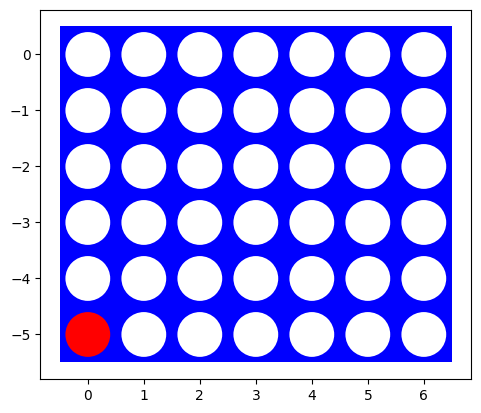

Board size 6x7 — Move took 0.0016 seconds.


In [48]:
# Your code/ answer goes here.
# Create an empty board
board = empty_board((6, 7))  # Standard 6x7 Connect Four board

# Function to count number of moves made (non-zero entries)
def count_moves(board):
    return np.count_nonzero(board)

# Dynamically choose depth limit
def choose_agent(board):
    num_moves = count_moves(board)
    if num_moves < 6:  # Early game, less pieces on board
        return MinimaxAgent(depth_limit=3)  # Shallow search
    else:  # Later game
        return MinimaxAgent(depth_limit=5)  # Deeper search allowed

# Example of using it:
agent = choose_agent(board)

# Now you can use the agent to make a move
start = time.time()
move = agent(board, player=1)
end = time.time()
# Visualize the board after the move (optional)
board = result(board, 1, move)
visualize(board)
print(f"Board size {6}x{7} — Move took {end - start:.4f} seconds.")


### Playtime [5 points]

Let the Minimax Search agent play a random agent on a $4 \times 4$ board. Analyze wins, losses and draws.

In [49]:
# Your code/ answer goes here.
def play_game(agent1, agent2, board_size=(4,4)):
    board = empty_board(board_size)
    agents = {1: agent1, -1: agent2}
    player = 1
    
    while not terminal(board):
        action = agents[player](board.copy(), player)
        board = result(board, player, action)
        player *= -1  # Switch players

    return utility(board, 1)  # Utility from agent1 (MinimaxAgent) perspective

# Setup agents
minimax_agent = MinimaxAgent(depth_limit=3)
random_agent = random_player

# Play multiple games
minimax_wins = 0
random_wins = 0
draws = 0
n_games = 100

for _ in range(n_games):
    result_game = play_game(minimax_agent, random_agent)
    
    if result_game == 1:
        minimax_wins += 1
    elif result_game == -1:
        random_wins += 1
    else:
        draws += 1

# Output results
print(f"Out of {n_games} games:")
print(f"Minimax Agent wins: {minimax_wins}")
print(f"Random Agent wins: {random_wins}")
print(f"Draws: {draws}")

Out of 100 games:
Minimax Agent wins: 73
Random Agent wins: 3
Draws: 24


## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function. Make sure that the heuristic value stays in the correct range.

In [50]:
# Your code/ answer goes here.
import numpy as np

# Check if a player has a winning line (horizontal, vertical, diagonal)
def check_winning_line(board, player):
    # Check horizontal
    for row in range(board.shape[0]):
        for col in range(board.shape[1] - 3):
            if np.all(board[row, col:col+4] == player):
                return True
    # Check vertical
    for row in range(board.shape[0] - 3):
        for col in range(board.shape[1]):
            if np.all(board[row:row+4, col] == player):
                return True
    # Check diagonal (down-right)
    for row in range(board.shape[0] - 3):
        for col in range(board.shape[1] - 3):
            if np.all([board[row+i, col+i] == player for i in range(4)]):
                return True
    # Check diagonal (down-left)
    for row in range(3, board.shape[0]):
        for col in range(board.shape[1] - 3):
            if np.all([board[row-i, col+i] == player for i in range(4)]):
                return True
    return False

In [51]:
# Heuristic evaluation function
def heuristic(board, player):
    # Check for win or lose (terminal states)
    if check_winning_line(board, player):
        return float('inf')  # Max score for a win
    elif check_winning_line(board, -player):
        return float('-inf')  # Min score for a loss

    score = 0
    # Evaluate each possible line for player and opponent
    for row in range(board.shape[0]):
        for col in range(board.shape[1] - 3):
            window = board[row, col:col+4]
            if np.count_nonzero(window == player) == 3 and np.count_nonzero(window == 0) == 1:
                score += 10  # Favorable condition (3-in-a-row for the player)
            elif np.count_nonzero(window == -player) == 3 and np.count_nonzero(window == 0) == 1:
                score -= 10  # Opponent's favorable condition (3-in-a-row)

    # Check vertical windows
    for col in range(board.shape[1]):
        for row in range(board.shape[0] - 3):
            window = board[row:row+4, col]
            if np.count_nonzero(window == player) == 3 and np.count_nonzero(window == 0) == 1:
                score += 10  # Favorable condition
            elif np.count_nonzero(window == -player) == 3 and np.count_nonzero(window == 0) == 1:
                score -= 10  # Opponent's favorable condition

    # Check diagonal windows (down-right)
    for row in range(board.shape[0] - 3):
        for col in range(board.shape[1] - 3):
            window = [board[row+i, col+i] for i in range(4)]
            if np.count_nonzero(window == player) == 3 and np.count_nonzero(window == 0) == 1:
                score += 10
            elif np.count_nonzero(window == -player) == 3 and np.count_nonzero(window == 0) == 1:
                score -= 10

    # Check diagonal windows (down-left)
    for row in range(3, board.shape[0]):
        for col in range(board.shape[1] - 3):
            window = [board[row-i, col+i] for i in range(4)]
            if np.count_nonzero(window == player) == 3 and np.count_nonzero(window == 0) == 1:
                score += 10
            elif np.count_nonzero(window == -player) == 3 and np.count_nonzero(window == 0) == 1:
                score -= 10

    # Return the final heuristic score (normalized between -100 and 100)
    return score

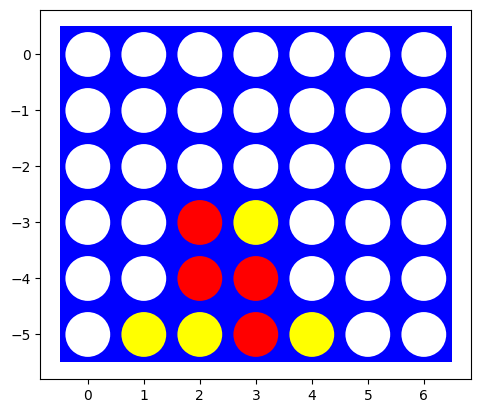

Heuristic score for player 1: 0


In [52]:

# Example of usage:
board = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, -1, 0, 0, 0],
                  [0, 0, 1, 1, 0, 0, 0],
                  [0, -1, -1, 1, -1, 0, 0]])

# Evaluate for player 1 (Red)
score = heuristic(board, 1)
visualize(board)
print(f"Heuristic score for player 1: {score}")


### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [53]:
import numpy as np

# Utility function to check if the game is in a terminal state
def terminal(board):
    return check_winning_line(board, 1) or check_winning_line(board, -1) or np.all(board != 0)

# Function to generate possible actions (moves)
def actions(board):
    return [col for col in range(board.shape[1]) if board[0, col] == 0]

# Function to simulate the result of a move
def result(board, player, move):
    new_board = board.copy()
    for row in range(board.shape[0] - 1, -1, -1):
        if new_board[row, move] == 0:
            new_board[row, move] = player
            break
    return new_board

# The utility function based on the heuristic evaluation (can be modified as needed)
def utility(board, player):
    return heuristic(board, player)

# Minimax Agent with alpha-beta pruning and depth limit
class MinimaxAgent:
    def __init__(self, depth_limit=4, use_ordering=False):
        self.depth_limit = depth_limit
        self.use_ordering = use_ordering
        self.nodes_searched = 0  # Optional: to track the number of nodes searched

    def __call__(self, board, player=1):
        best_score = float('-inf')
        best_move = None
        alpha = float('-inf')
        beta = float('inf')

        possible_moves = actions(board)
        
        if self.use_ordering:
            possible_moves = self.order_moves(board, possible_moves, player)

        for move in possible_moves:
            new_board = result(board, player, move)
            score = self.min_value(new_board, self.depth_limit - 1, alpha, beta, -player)
            if score > best_score:
                best_score = score
                best_move = move
            alpha = max(alpha, best_score)

        return best_move

    def max_value(self, board, depth, alpha, beta, player):
        self.nodes_searched += 1
        if terminal(board) or depth == 0:
            return utility(board, player)

        value = float('-inf')
        for move in actions(board):
            value = max(value, self.min_value(result(board, player, move), depth - 1, alpha, beta, -player))
            if value >= beta:
                return value
            alpha = max(alpha, value)
        return value

    def min_value(self, board, depth, alpha, beta, player):
        self.nodes_searched += 1
        if terminal(board) or depth == 0:
            return utility(board, -player)

        value = float('inf')
        for move in actions(board):
            value = min(value, self.max_value(result(board, player, move), depth - 1, alpha, beta, -player))
            if value <= alpha:
                return value
            beta = min(beta, value)
        return value

    # Simple move ordering function (can be improved for efficiency)
    def order_moves(self, board, moves, player):
        # This example simply sorts moves based on the potential of immediate wins (can be optimized)
        move_scores = {}
        for move in moves:
            new_board = result(board, player, move)
            move_scores[move] = utility(new_board, player)
        return sorted(moves, key=lambda move: move_scores[move], reverse=True)

In [54]:
# Create an empty 4x4 board
board = np.zeros((4, 4), dtype=int)

# Create the Minimax agent with alpha-beta pruning
agent = MinimaxAgent(depth_limit=4, use_ordering=True)

# Let the agent play a move (player 1 is the starting player)
move = agent(board, player=1)
print(f"Chosen move: {move}")

Chosen move: 0


Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [55]:
# Your code/ answer goes here.
import numpy as np

# Define some test boards (as 6x7 arrays)
board_1 = np.array([
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [1,1,1,0],    
])  

board_2 = np.array([
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [-1,-1,-1,0], 
])

board_3 = np.array([
    [0,0,0,0],
    [0,0,1,1],
    [0,1,-1,-1],
    [1,-1,1,-1], 
]) 

board_4 = np.array([
    [0,0,0,0],
    [-1,-1,1,-1],
    [1,1,-1,1],
    [1,-1,1,-1], 
])  

board_5 = np.array([
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0], 
])  


Board 1:


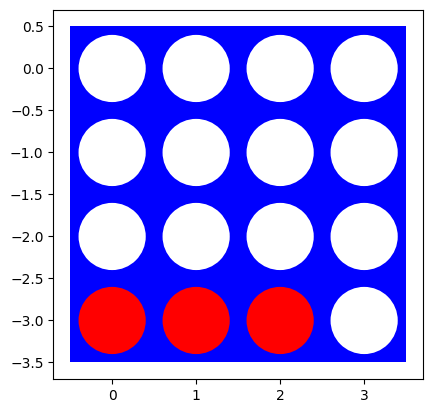

Agent's move: 3
------------------------------
Board 2:


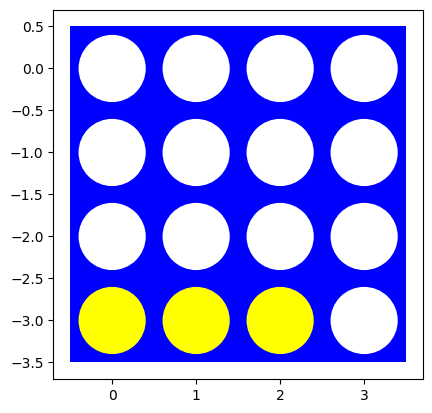

Agent's move: 3
------------------------------
Board 3:


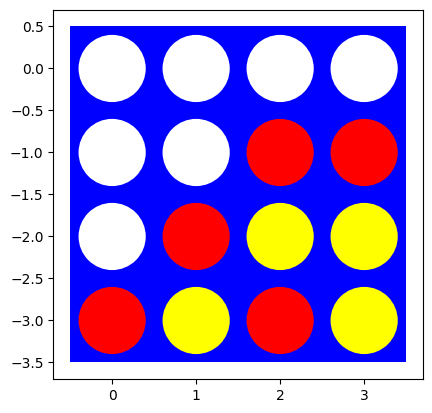

Agent's move: 3
------------------------------
Board 4:


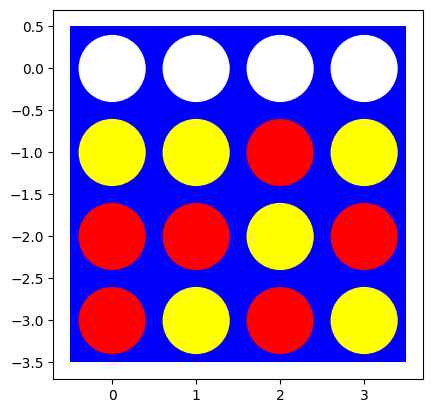

Agent's move: 3
------------------------------
Board 5:


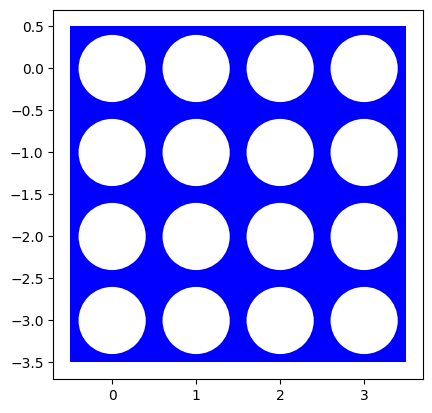

Agent's move: 0
------------------------------


In [56]:
# Test with MinimaxAgent (using depth limit 4 and move ordering)
agent = MinimaxAgent(depth_limit=6, use_ordering=True)

# Test the agent on each manually created board
boards = [board_1, board_2, board_3, board_4, board_5]
for i, board in enumerate(boards, 1):
    print(f"Board {i}:")
    visualize(board)
    move = agent(board, player=1)  # Player 1 (red) is the starting player
    print(f"Agent's move: {move}")
    print("-" * 30)


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [57]:
# Experiment function to measure time for different board sizes
def measure_move_time(board_size):
    board = np.zeros((board_size, board_size), dtype=int)  # Initialize empty board
    agent = MinimaxAgent(depth_limit=4, use_ordering=True)

    start_time = time.time()  # Start time
    agent(board, player=1)  # Let agent make a move
    end_time = time.time()  # End time

    return round(end_time - start_time, 4)  # Time in seconds


In [58]:
# Your code/ answer goes here.
# Experiment with various board sizes (4x4, 5x5, 6x6, 7x7)
board_sizes = [4, 5, 6, 7]
times = []

for size in board_sizes:
    move_time = measure_move_time(size)
    times.append((size, move_time))

# Print the results in a table-like format
print("Board Size (n x n) | Time Taken (seconds)")
print("-" * 40)
for size, time_taken in times:
    print(f"{size}x{size}             | {time_taken}")

Board Size (n x n) | Time Taken (seconds)
----------------------------------------
4x4             | 0.0042
5x5             | 0.0187
6x6             | 0.0483
7x7             | 0.1016


### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [59]:
# Your code/ answer goes here.
import numpy as np

# Define the board size
BOARD_ROWS = 6
BOARD_COLS = 7

# MinimaxAgent class with alpha-beta pruning and heuristic evaluation
class MinimaxAgent:
    def __init__(self, depth_limit=4, heuristic_fn=None):
        self.depth_limit = depth_limit
        self.heuristic_fn = heuristic_fn

    def __call__(self, board, player):
        best_score = float('-inf')
        best_move = None
        alpha = float('-inf')
        beta = float('inf')

        for move in self.actions(board):
            new_board = self.result(board, player, move)
            score = self.min_value(new_board, self.depth_limit - 1, alpha, beta, -player)
            if score > best_score:
                best_score = score
                best_move = move
            alpha = max(alpha, best_score)

        return best_move

    def max_value(self, board, depth, alpha, beta, player):
        if self.terminal(board) or depth == 0:
            return self.heuristic_fn(board, player)

        value = float('-inf')
        for move in self.actions(board):
            value = max(value, self.min_value(self.result(board, player, move), depth - 1, alpha, beta, -player))
            if value >= beta:
                return value
            alpha = max(alpha, value)
        return value

    def min_value(self, board, depth, alpha, beta, player):
        if self.terminal(board) or depth == 0:
            return self.heuristic_fn(board, player)

        value = float('inf')
        for move in self.actions(board):
            value = min(value, self.max_value(self.result(board, player, move), depth - 1, alpha, beta, -player))
            if value <= alpha:
                return value
            beta = min(beta, value)
        return value

    def actions(self, board):
        return [(r, c) for r in range(BOARD_ROWS) for c in range(BOARD_COLS) if board[r, c] == 0]

    def result(self, board, player, move):
        new_board = board.copy()
        new_board[move] = player
        return new_board

    def terminal(self, board):
        # Terminal condition: either win, full board, or draw
        return np.all(board != 0) or self.check_winner(board, 1) or self.check_winner(board, -1)

    def check_winner(self, board, player):
        # Check for winning condition for the given player
        for r in range(BOARD_ROWS):
            for c in range(BOARD_COLS):
                if board[r, c] == player:
                    if self.check_direction(board, r, c, 1, 0, player) or \
                       self.check_direction(board, r, c, 0, 1, player) or \
                       self.check_direction(board, r, c, 1, 1, player) or \
                       self.check_direction(board, r, c, 1, -1, player):
                        return True
        return False

    def check_direction(self, board, r, c, dr, dc, player):
        # Check if there are 4 consecutive pieces in a given direction
        for i in range(4):
            nr = r + i * dr
            nc = c + i * dc
            if nr < 0 or nr >= BOARD_ROWS or nc < 0 or nc >= BOARD_COLS or board[nr, nc] != player:
                return False
        return True

# Heuristic evaluation functions
def simple_heuristic(board, player):
    return np.random.randint(-1, 2)  # Simplified heuristic: random score for now (can be improved)

def offensive_heuristic(board, player):
    # A simple heuristic that tries to prioritize offensive plays (finding opportunities for 4 in a row)
    score = 0
    for r in range(BOARD_ROWS):
        for c in range(BOARD_COLS):
            if board[r, c] == player:
                if (r + 3 < BOARD_ROWS and np.all(board[r:r+4, c] == player)):  # Check vertical line
                    score += 10
                if (c + 3 < BOARD_COLS and np.all(board[r, c:c+4] == player)):  # Check horizontal line
                    score += 10
    return score

# Initialize the board
def initialize_board():
    return np.zeros((BOARD_ROWS, BOARD_COLS), dtype=int)

# Play the game
def play_game(agent1, agent2):
    board = initialize_board()
    current_player = 1  # Player 1 starts (Red)
    while True:
        if current_player == 1:
            move = agent1(board, current_player)
        else:
            move = agent2(board, current_player)

        if move is None:
            break  # No valid moves, game ends (draw or full board)
        board[move] = current_player
        if agent1.terminal(board) or agent2.terminal(board):
            break  # Game over (win or draw)

        current_player = -current_player  # Switch players

    return board


Final board after the game:


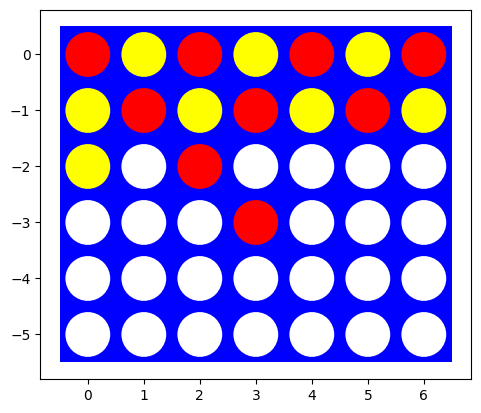

Player 1 (Red) wins!


In [60]:
# Set up the agents with different parameters
agent1 = MinimaxAgent(depth_limit=4, heuristic_fn=simple_heuristic)
agent2 = MinimaxAgent(depth_limit=3, heuristic_fn=offensive_heuristic)

# Play the game once
final_board = play_game(agent1, agent2)

# Print the final board state
print("Final board after the game:")
visualize(final_board)

# Check the winner
if agent1.check_winner(final_board, 1):
    print("Player 1 (Red) wins!")
elif agent1.check_winner(final_board, -1):
    print("Player 2 (Yellow) wins!")
else:
    print("It's a draw!")

Final board after the game:


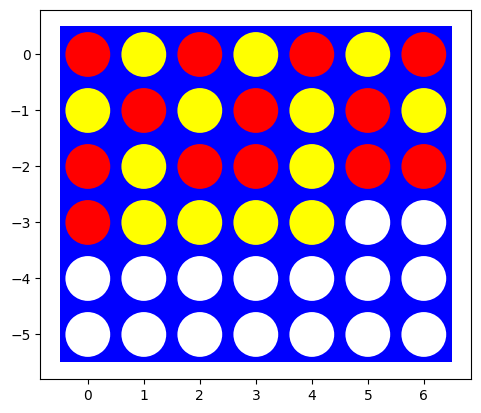

Player 2 (Yellow) wins!


In [61]:
# Set up the agents with different parameters
agent1 = MinimaxAgent(depth_limit=4, heuristic_fn=offensive_heuristic)
agent2 = MinimaxAgent(depth_limit=3, heuristic_fn=simple_heuristic)

# Play the game once
final_board = play_game(agent1, agent2)

# Print the final board state
print("Final board after the game:")
visualize(final_board)

# Check the winner
if agent1.check_winner(final_board, 1):
    print("Player 1 (Red) wins!")
elif agent1.check_winner(final_board, -1):
    print("Player 2 (Yellow) wins!")
else:
    print("It's a draw!")

## Challenge task [up to +10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

In [64]:
import numpy as np

ROWS = 6
COLUMNS = 7
EMPTY = 0
PLAYER_X = 1  # "X"
PLAYER_O = -1  # "O"

# Initialize an empty board
def empty_board():
    return np.zeros((ROWS, COLUMNS), dtype=int)

# Return valid actions (columns that are not full)
def actions(board):
    return [col for col in range(COLUMNS) if board[0][col] == EMPTY]

# Drop a piece into the lowest empty spot in the chosen column
def result(board, player, action):
    new_board = board.copy()
    for row in reversed(range(ROWS)):
        if new_board[row][action] == EMPTY:
            new_board[row][action] = player
            break
    return new_board

# Check for terminal state and return (is_terminal, utility)
def terminal(board):
    # Horizontal, vertical, and diagonal checks for a winner
    def check_winner(player):
        # Horizontal
        for r in range(ROWS):
            for c in range(COLUMNS - 3):
                if np.all(board[r, c:c+4] == player):
                    return True
        # Vertical
        for r in range(ROWS - 3):
            for c in range(COLUMNS):
                if np.all(board[r:r+4, c] == player):
                    return True
        # Diagonal /
        for r in range(3, ROWS):
            for c in range(COLUMNS - 3):
                if all(board[r-i][c+i] == player for i in range(4)):
                    return True
        # Diagonal \
        for r in range(ROWS - 3):
            for c in range(COLUMNS - 3):
                if all(board[r+i][c+i] == player for i in range(4)):
                    return True
        return False

    if check_winner(PLAYER_X):
        return True, +1
    if check_winner(PLAYER_O):
        return True, -1
    if np.all(board != EMPTY):
        return True, 0  # Draw
    return False, None  # Game not over

# Heuristic evaluation function
def heuristic(board, player):
    score = 0
    # Evaluation function can be enhanced based on position, threats, etc.
    def count_possible_lines(board, player):
        lines = 0
        for r in range(ROWS):
            for c in range(COLUMNS - 3):
                window = board[r, c:c+4]
                if np.count_nonzero(window == player) == 3 and np.count_nonzero(window == EMPTY) == 1:
                    lines += 1
        return lines

    # Count possible lines for the player (more lines = better)
    score += count_possible_lines(board, player)
    # Count opponent's possible lines (fewer lines = better)
    score -= count_possible_lines(board, -player)
    return score

# Minimax algorithm with Alpha-Beta pruning
class MinimaxAgent:
    def __init__(self, depth_limit=5, use_ordering=True):
        self.depth_limit = depth_limit
        self.use_ordering = use_ordering

    def __call__(self, board, player=1):
        best_score = float('-inf')
        best_move = None
        alpha = float('-inf')
        beta = float('inf')

        for move in self.ordered_actions(board) if self.use_ordering else actions(board):
            new_board = result(board, player, move)
            score = self.min_value(new_board, self.depth_limit - 1, alpha, beta, -player)
            if score > best_score:
                best_score = score
                best_move = move
            alpha = max(alpha, best_score)

        return best_move

    def max_value(self, board, depth, alpha, beta, player):
        if terminal(board)[0] or depth == 0:
            return heuristic(board, player)

        value = float('-inf')
        for move in actions(board):
            value = max(value, self.min_value(result(board, player, move), depth - 1, alpha, beta, -player))
            if value >= beta:
                return value
            alpha = max(alpha, value)
        return value

    def min_value(self, board, depth, alpha, beta, player):
        if terminal(board)[0] or depth == 0:
            return heuristic(board, -player)

        value = float('inf')
        for move in actions(board):
            value = min(value, self.max_value(result(board, player, move), depth - 1, alpha, beta, -player))
            if value <= alpha:
                return value
            beta = min(beta, value)
        return value

    def ordered_actions(self, board):
        # Move ordering by starting in the center
        cols = board.shape[1]
        center = cols // 2
        order = [center]

        for offset in range(1, center + 1):
            if center - offset >= 0:
                order.append(center - offset)
            if center + offset < cols:
                order.append(center + offset)

        return [col for col in order if board[0, col] == EMPTY]

# Simulate a simple game between two agents
def play_game(agent_x, agent_o):
    board = empty_board()
    player = PLAYER_X

    while True:
        if player == PLAYER_X:
            move = agent_x(board, player)
        else:
            move = agent_o(board, player)

        board = result(board, player, move)
        is_terminal_state, utility = terminal(board)

        if is_terminal_state:
            return utility  # Return the result of the game (1 for X win, -1 for O win, 0 for draw)

        player = -player  # Switch player

# Tournament simulation
def tournament(agent_x, agent_o, games=10):
    results = {PLAYER_X: 0, PLAYER_O: 0, "Draw": 0}
    for _ in range(games):
        result = play_game(agent_x, agent_o)
        if result == 1:
            results[PLAYER_X] += 1
        elif result == -1:
            results[PLAYER_O] += 1
        else:
            results["Draw"] += 1

    print(f"Results after {games} games:")
    print(f"Player X (Agent 1): {results[PLAYER_X]} wins")
    print(f"Player O (Agent 2): {results[PLAYER_O]} wins")
    print(f"Draws: {results['Draw']}")

# Example usage: Play a tournament
agent_x = MinimaxAgent(depth_limit=5, use_ordering=True)
agent_o = MinimaxAgent(depth_limit=5, use_ordering=True)

tournament(agent_x, agent_o, games=100)


Results after 100 games:
Player X (Agent 1): 0 wins
Player O (Agent 2): 0 wins
Draws: 100


## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

### Best First Move

Use your Monte Carlo Search to determine what the best first move for red is? Describe under what assumptions this is the "best" first move.  

In [74]:
import random
import numpy as np

ROWS = 6
COLUMNS = 7
PLAYER_X = 1  # "X"
PLAYER_O = -1  # "O"
EMPTY = 0

# Initialize an empty board
def initial_state():
    return np.zeros((ROWS, COLUMNS), dtype=int), PLAYER_X

# Return valid actions (columns that are not full)
def actions(state):
    board, _ = state
    return [col for col in range(COLUMNS) if board[0][col] == EMPTY]

# Drop a piece into the lowest empty spot in the chosen column
def result(state, player, action):
    board, _ = state
    new_board = board.copy()
    for row in reversed(range(ROWS)):
        if new_board[row][action] == EMPTY:
            new_board[row][action] = player
            break
    return new_board, -player

# Check for terminal state and return (is_terminal, utility)
def is_terminal(state):
    board, _ = state

    def check_winner(player):
        # Horizontal
        for r in range(ROWS):
            for c in range(COLUMNS - 3):
                if np.all(board[r, c:c+4] == player):
                    return True
        # Vertical
        for r in range(ROWS - 3):
            for c in range(COLUMNS):
                if np.all(board[r:r+4, c] == player):
                    return True
        # Diagonal /
        for r in range(3, ROWS):
            for c in range(COLUMNS - 3):
                if all(board[r-i][c+i] == player for i in range(4)):
                    return True
        # Diagonal \
        for r in range(ROWS - 3):
            for c in range(COLUMNS - 3):
                if all(board[r+i][c+i] == player for i in range(4)):
                    return True
        return False

    if check_winner(PLAYER_X):
        return True, +1
    if check_winner(PLAYER_O):
        return True, -1
    if np.all(board != EMPTY):
        return True, 0  # Draw
    return False, None  # Game not over

def simulate_game(state, player):
    """
    Simulate a random game from a given state until it ends.
    Returns the utility (+1, -1, or 0 for draw).
    """
    board, current_player = state
    while True:
        valid_moves = actions(state)
        if not valid_moves:
            print("No valid moves left, returning 0 (draw)")
            return 0  # Draw, no valid moves left
        move = random.choice(valid_moves)
        new_state = result(state, current_player, move)
        board, current_player = new_state
        terminal, utility = is_terminal((board, current_player))
        if terminal:
            print(f"Terminal state reached with utility: {utility}")
            return utility


def monte_carlo_search(state, player, simulations=100):
    """
    Perform Monte Carlo Search to determine the best move.
    Simulate `simulations` random games and return the best move based on simulations.
    """
    best_move = None
    best_wins = -float('inf')
    
    for move in actions(state):
        total_wins = 0
        for _ in range(simulations):
            new_state = result(state, player, move)
            simulation_result = simulate_game(new_state, -player)  # opponent starts after the move
            if simulation_result == player:
                total_wins += 1
        if total_wins > best_wins:
            best_wins = total_wins
            best_move = move
    
    return best_move



In [77]:
board, player = initial_state()
simulations = 1  # Number of random games to simulate per move

# Get the best move from Monte Carlo Search
best_move = monte_carlo_search((board, player), player, 1)
print(f"Best move chosen by Monte Carlo Search: {best_move}")

KeyboardInterrupt: 